In [2]:
pip install numpy pandas matplotlib statsmodels arch

Note: you may need to restart the kernel to use updated packages.


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA  
from statsmodels.stats.diagnostic import acorr_ljungbox  

from statsmodels.nonparametric.smoothers_lowess import lowess
from arch import arch_model

plt.rcParams['figure.figsize'] = (10, 6)

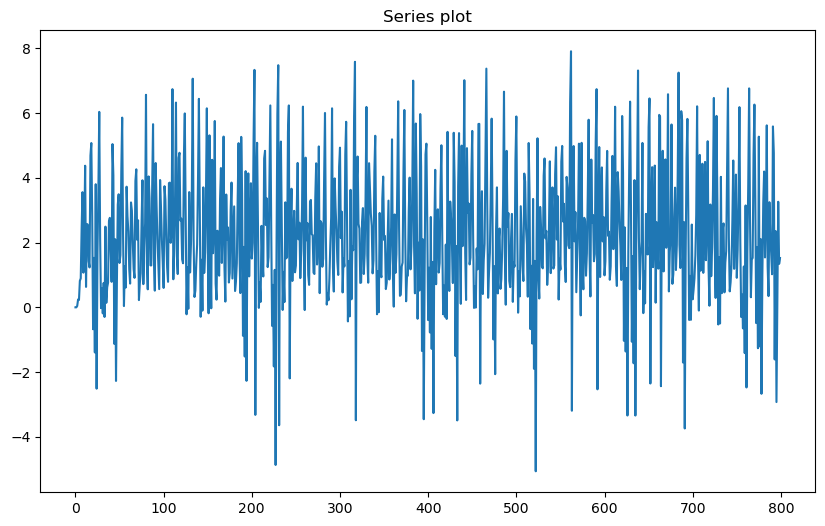

In [69]:
df=pd.read_csv(r"C:\Users\snehi\Documents\Advanced TSA\Assignment 1\comp_ex_1_scrips_2018\DataPart5.csv")
y = df['x'].astype(float)
#cleaning the null values
#y = y.dropna()

y.plot(title="Series plot")
plt.show()

In [18]:
#checking if the series is stationary or not
adf_stat, pval, *_ = adfuller(y.values, autolag='AIC')
print("ADF p-value:", pval)

ADF p-value: 0.0


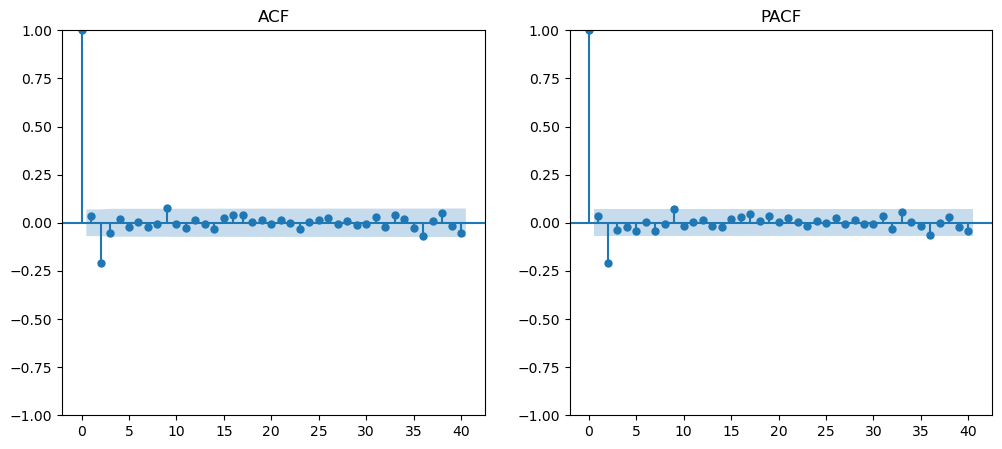

In [19]:


fig, ax = plt.subplots(1,2,figsize=(12,5))
plot_acf(y, lags=40, ax=ax[0])
plot_pacf(y, lags=40, ax=ax[1], method='ywm')
ax[0].set_title("ACF")
ax[1].set_title("PACF")
plt.show()

In [25]:
# the above plot suggests that the series is stationary and we can proceed to fit an ARMA model. And it seems to be an AR(2) model. 
# Proceeding further to confirm this.
ar2 = ARIMA(y, order=(2,0,0)).fit()
print("AR(2)  AIC:", ar2.aic, "BIC:", ar2.bic)

# Compare with your 'final' model (best ARMA from grid search)
print("Best-by-grid:", arma.aic, arma.bic)


AR(2)  AIC: 3422.7923939475127 BIC: 3441.5308408581845
Best-by-grid: 3422.083078904497 3445.5061375428368


In [30]:
#a better way of confirming the model type is by grid search for best (p,q) by AIC
import warnings
warnings.filterwarnings("ignore")

candidates = []
for p in range(0, 4):      # widen if needed
    for q in range(0, 4):
        if p == 0 and q == 0: 
            continue
        try:
            model = ARIMA(y, order=(p,0,q)).fit()
            candidates.append(((p,q), model.aic))
        except Exception:
            pass

candidates = sorted(candidates, key=lambda x: x[1])
print(candidates[:5])  # see top AICs


[((0, 3), 3422.083078904497), ((1, 2), 3422.714345669029), ((2, 0), 3422.7923939475127), ((2, 1), 3423.215356506573), ((1, 3), 3423.226247221378)]


In [63]:
# AFTER you fit: ma3 = ARIMA(y_st, order=(0,0,3)).fit()
#grab MA coefficients θ1, θ2, θ3 in lag order
ma_names = sorted([n for n in ma3.params.index if n.startswith('ma.L')],
                  key=lambda s: int(s.split('L')[-1]))
theta = np.array([ma3.params[n] for n in ma_names])  # [θ1, θ2, θ3]

#build polynomial 1 + θ1 z + θ2 z^2 + θ3 z^3
# np.roots expects highest power first -> [θ3, θ2, θ1, 1]
coeffs = np.r_[theta[::-1], 1.0]

#compute roots and check invertibility
roots = np.roots(coeffs)
moduli = np.abs(roots)
is_invertible = np.all(moduli > 1.0)

print("MA roots:", roots)
print("Moduli:", moduli)
print("Invertible?", is_invertible)


MA roots: [-2.47670614+1.48882706j -2.47670614-1.48882706j  1.77824691+0.j        ]
Moduli: [2.8897542  2.8897542  1.77824691]
Invertible? True


                               SARIMAX Results                                
Dep. Variable:                      x   No. Observations:                  800
Model:                 ARIMA(0, 0, 3)   Log Likelihood               -1706.042
Date:                Mon, 29 Sep 2025   AIC                           3422.083
Time:                        15:37:57   BIC                           3445.506
Sample:                             0   HQIC                          3431.081
                                - 800                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2354      0.060     37.043      0.000       2.117       2.354
ma.L1          0.0308      0.039      0.798      0.425      -0.045       0.107
ma.L2         -0.2138      0.035     -6.180      0.0

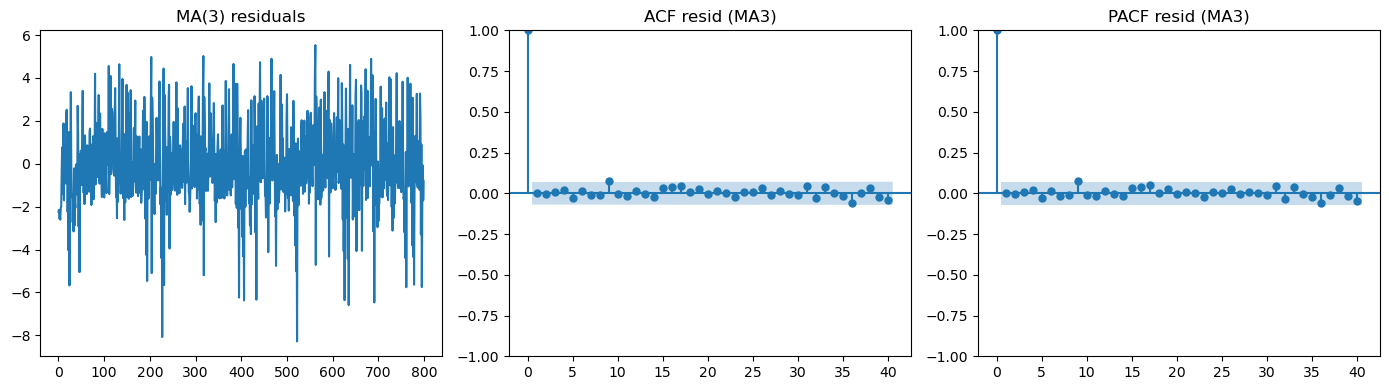

Ljung–Box (MA3):
       lb_stat  lb_pvalue
10   5.998549   0.815385
20  11.412332   0.934821
30  13.302890   0.996359


In [36]:
#now here, we can see that the best model is indeed MA(3) based on the AIC values, so now we run both, and run the same residual diagnostics 
# on both the models and see which one is better.

#fitting MA(3) and extracting residuals
# MA(3): ARIMA(order=(0,0,3))
ma3 = ARIMA(y, order=(0,0,3)).fit()
print(ma3.summary())          # see params + AIC/BIC
resid_ma3 = ma3.resid

#diagnosing the residuals of MA(3)
# Residual ACF/PACF
fig, ax = plt.subplots(1,3, figsize=(14,4))
ax[0].plot(resid_ma3); ax[0].set_title("MA(3) residuals")
plot_acf(resid_ma3, lags=40, ax=ax[1]); ax[1].set_title("ACF resid (MA3)")
plot_pacf(resid_ma3, lags=40, ax=ax[2], method='ywm'); ax[2].set_title("PACF resid (MA3)")
plt.tight_layout(); plt.show()

# Ljung–Box whiteness test
lb_ma3 = acorr_ljungbox(resid_ma3, lags=[10,20,30], return_df=True)
print("Ljung–Box (MA3):\n", lb_ma3)


       order          AIC          BIC  white
0  (2, 0, 0)  3422.792394  3441.530841   True
1  (0, 0, 3)  3422.083079  3445.506138   True
2  (1, 0, 1)  3448.985521  3467.723967  False

Model (2, 0, 0) LB p-values:
       lb_stat  lb_pvalue
10   8.504153   0.579716
20  13.700261   0.845362
30  15.713008   0.985044


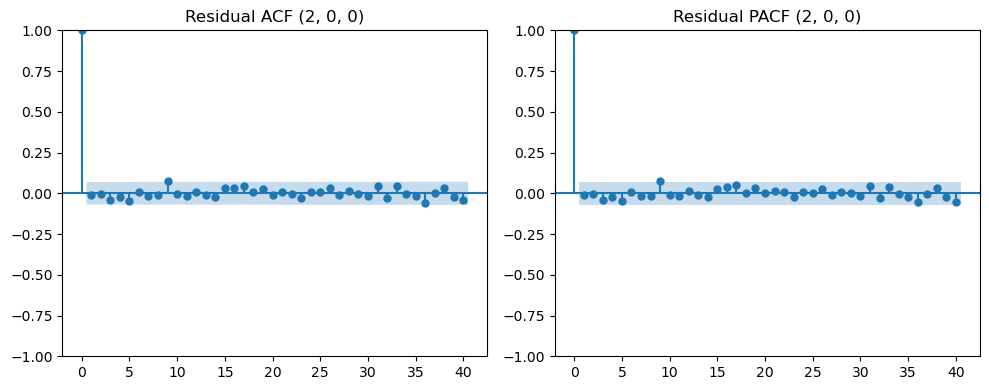


Model (0, 0, 3) LB p-values:
       lb_stat  lb_pvalue
10   5.998549   0.815385
20  11.412332   0.934821
30  13.302890   0.996359


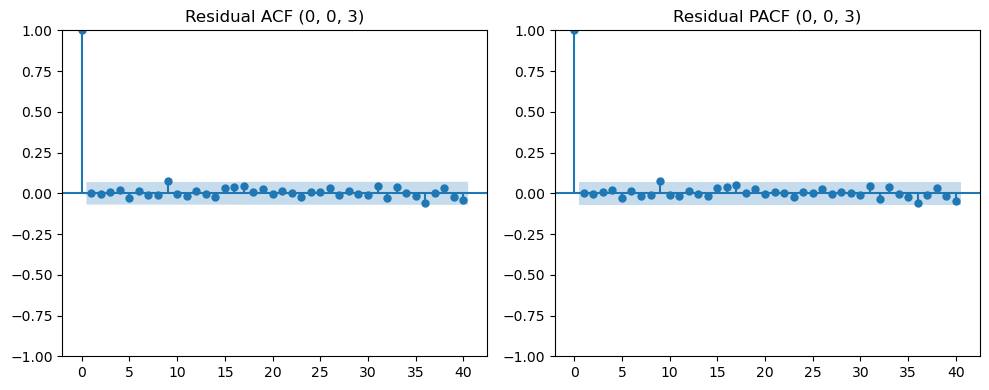

In [ ]:
#now here, we can see that the best model is indeed MA(3) based on the AIC values, so now we run both, and run the same residual diagnostics 
# on both the models and see which one is better.

#now fitting and extracting residuals
def fit_and_diag(y, order, lb_lags=(10,20,30), title=""):
    m = ARIMA(y, order=order).fit()
    resid = m.resid
    lb = acorr_ljungbox(resid, lags=list(lb_lags), return_df=True)
    is_white = (lb["lb_pvalue"] > 0.05).all() 
    return {
        "order": order,
        "AIC": m.aic,
        "BIC": m.bic,
        "white": is_white,
        "lb": lb,
        "model": m
    }

cands = [(2,0,0), (0,0,3), (1,0,1)]   # AR(2), MA(3), ARMA(1,1) for example
results = [fit_and_diag(y, o) for o in cands]

#comparing
tbl = pd.DataFrame([{"order":r["order"], "AIC":r["AIC"], "BIC":r["BIC"], "white":r["white"]} for r in results])
print(tbl.sort_values(["white","BIC","AIC"], ascending=[False, True, True]))

best_whites = [r for r in results if r["white"]]
for r in best_whites:
    print("\nModel", r["order"], "LB p-values:\n", r["lb"])
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    plot_acf(r["model"].resid, lags=40, ax=ax[0]); ax[0].set_title(f"Residual ACF {r['order']}")
    plot_pacf(r["model"].resid, lags=40, method='ywm', ax=ax[1]); ax[1].set_title(f"Residual PACF {r['order']}")
    plt.tight_layout(); plt.show()

Significant LDF lags (residuals): [1, 2, 3, 4, 6]


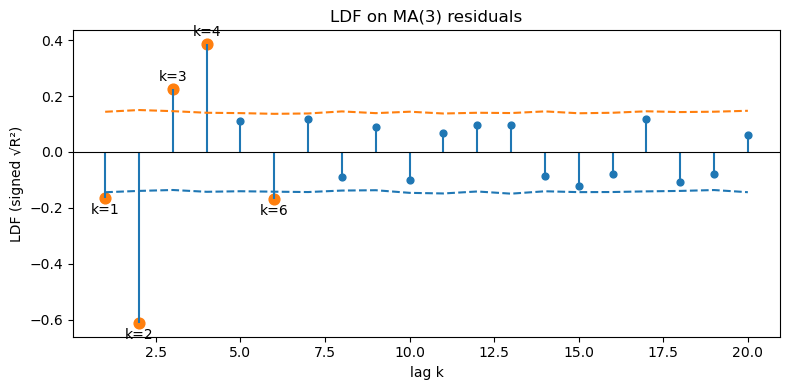

In [81]:
#now we can say based on BIC values that it is an MA(3) model
#testing for nonlinear dependence in the residuals
from statsmodels.nonparametric.smoothers_lowess import lowess

def ldf_one_lag_lowess(e, k, span=0.30):
    """
    LDF at lag k using LOWESS (signed sqrt(R^2)).
    e: 1D array of residuals
    k: lag (>=1)
    span: LOWESS fraction (0..1); larger = smoother
    """
    e = np.asarray(e, float)
    x, y = e[:-k], e[k:]                   # x = e_{t-k}, y = e_t
    yhat = lowess(y, x, frac=span, it=0, return_sorted=False)

    ss_tot = np.sum((y - y.mean())**2)
    ss_res = np.sum((y - yhat)**2)
    r2 = max(0.0, 1.0 - ss_res/ss_tot)

    # sign from fitted change between min(x) and max(x)
    i_min, i_max = np.argmin(x), np.argmax(x)
    sgn = np.sign(yhat[i_max] - yhat[i_min])
    return float(sgn * np.sqrt(r2))

def ldf_with_boot_bands(e, k, nboot=300, span=0.30, alpha=0.05, seed=42):
    """
    LDF value + two-sided bootstrap bands under i.i.d. noise.
    Returns (value, lower_band, upper_band).
    """
    rng = np.random.default_rng(seed)
    val = ldf_one_lag_lowess(e, k, span=span)
    boots = []
    for _ in range(nboot):
        eb = rng.choice(e, size=len(e), replace=True)
        boots.append(ldf_one_lag_lowess(eb, k, span=span))
    lo, hi = np.quantile(boots, [alpha/2, 1 - alpha/2])
    return val, lo, hi

#compute LDF over lags 
K = 20
SPAN = 0.30
NBOOT = 300
ALPHA = 0.05
SEED = 42

vals, los, his = [], [], []
for k in range(1, K+1):
    v, lo, hi = ldf_with_boot_bands(resid_ma3, k, nboot=NBOOT,
                                    span=SPAN, alpha=ALPHA, seed=SEED)
    vals.append(v); los.append(lo); his.append(hi)

vals = np.array(vals); los = np.array(los); his = np.array(his)
x = np.arange(1, K+1)

#significant lags (outside the bands)
sig_mask = (vals < los) | (vals > his)
sig_lags = x[sig_mask].tolist()
print("Significant LDF lags (residuals):", sig_lags)

#plot
plt.figure(figsize=(8,4))
plt.vlines(x, 0, vals)            # stems
plt.scatter(x, vals, s=24)        # markers
plt.plot(x, los, '--')            # lower band
plt.plot(x, his, '--')            # upper band
plt.axhline(0, lw=0.8, color='k')
#highlight and label significant lags
if np.any(sig_mask):
    plt.scatter(x[sig_mask], vals[sig_mask], s=60)
    for xi, yi in zip(x[sig_mask], vals[sig_mask]):
        offset = 0.02 if yi >= 0 else -0.02
        plt.text(xi, yi + offset, f"k={xi}", ha='center',
                 va='bottom' if yi >= 0 else 'top')
plt.xlabel("lag k"); plt.ylabel("LDF (signed √R²)")
plt.title("LDF on MA(3) residuals")
plt.tight_layout(); plt.show()



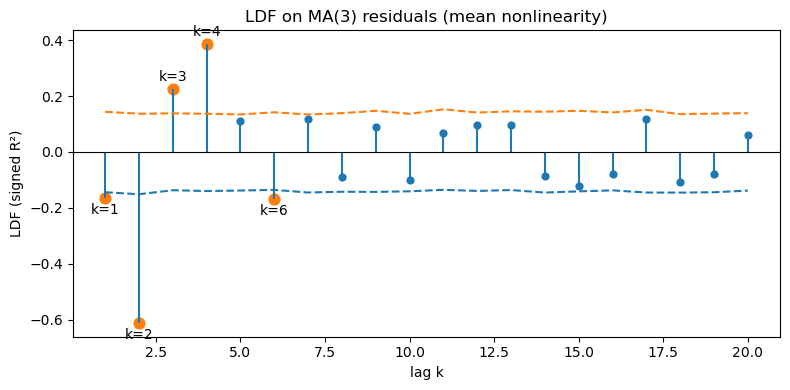

Significant LDF lags: [1, 2, 3, 4, 6]


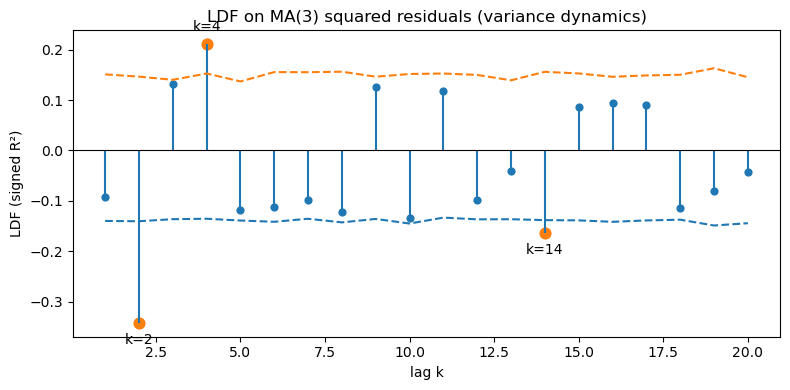

Significant LDF lags: [2, 4, 14]


In [82]:
#the above plot is showing that there are many spikes so it means the MA(3) residuals are not i.i.d.
# seeing if it's mean nonlinearity or variance dynamics, running LDF on squared residuals now

def ldf_one_lag(e, k, frac=0.30):
    """Signed sqrt(R^2) LDF at lag k using LOWESS."""
    e = np.asarray(e, float)
    x, y = e[:-k], e[k:]
    yhat = lowess(y, x, frac=frac, it=0, return_sorted=False)

    ss_tot = np.sum((y - y.mean())**2)
    ss_res = np.sum((y - yhat)**2)
    r2 = max(0.0, 1.0 - ss_res/ss_tot)

    i_min, i_max = np.argmin(x), np.argmax(x)
    sgn = np.sign(yhat[i_max] - yhat[i_min])
    return float(sgn * np.sqrt(r2))

def ldf_with_bands(e, k, nboot=300, frac=0.30, alpha=0.05, rng=None):
    """LDF value + two-sided bootstrap bands under i.i.d. noise."""
    if rng is None:
        rng = np.random.default_rng()
    val = ldf_one_lag(e, k, frac=frac)
    boots = [ldf_one_lag(rng.choice(e, size=len(e), replace=True), k, frac=frac)
             for _ in range(nboot)]
    lo, hi = np.quantile(boots, [alpha/2, 1 - alpha/2])
    return val, lo, hi

def compute_ldf_series(e, K, nboot=300, frac=0.30, alpha=0.05, seed=42):
    rng = np.random.default_rng(seed)
    vals, los, his = [], [], []
    for k in range(1, K+1):
        v, lo, hi = ldf_with_bands(e, k, nboot=nboot, frac=frac, alpha=alpha, rng=rng)
        vals.append(v); los.append(lo); his.append(hi)
    return np.array(vals), np.array(los), np.array(his)

def plot_ldf(vals, los, his, title):
    x = np.arange(1, len(vals)+1)
    sig = (vals < los) | (vals > his)
    sig_lags = x[sig].tolist()

    plt.figure(figsize=(8,4))
    plt.vlines(x, 0, vals)
    plt.scatter(x, vals, s=24)
    plt.plot(x, los, '--'); plt.plot(x, his, '--')
    plt.axhline(0, lw=0.8, color='k')
    if np.any(sig):
        plt.scatter(x[sig], vals[sig], s=60)
        for xi, yi in zip(x[sig], vals[sig]):
            plt.text(xi, yi + (0.02 if yi >= 0 else -0.02), f"k={xi}",
                     ha='center', va='bottom' if yi >= 0 else 'top')
    plt.xlabel("lag k"); plt.ylabel("LDF (signed R²)")
    plt.title(title)
    plt.tight_layout(); plt.show()
    print(f"Significant LDF lags: {sig_lags}")
    return sig_lags

# -------- Run: residuals --------
K = 20
vals, los, his = compute_ldf_series(resid_ma3, K, nboot=300, frac=0.30, alpha=0.05, seed=42)
sig_lags = plot_ldf(vals, los, his, title="LDF on MA(3) residuals (mean nonlinearity)")

# -------- Run: squared residuals (variance) --------
res2 = (resid_ma3 - np.mean(resid_ma3))**2
vals2, los2, his2 = compute_ldf_series(res2, K, nboot=300, frac=0.30, alpha=0.05, seed=43)
sig_lags_sq = plot_ldf(vals2, los2, his2, title="LDF on MA(3) squared residuals (variance dynamics)")

                          Zero Mean - GARCH Model Results                           
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.001
Vol Model:                            GARCH   Log-Likelihood:               -1693.29
Distribution:      Standardized Student's t   AIC:                           3394.58
Method:                  Maximum Likelihood   BIC:                           3413.32
                                              No. Observations:                  800
Date:                      Tue, Sep 30 2025   Df Residuals:                      800
Time:                              13:46:13   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
o

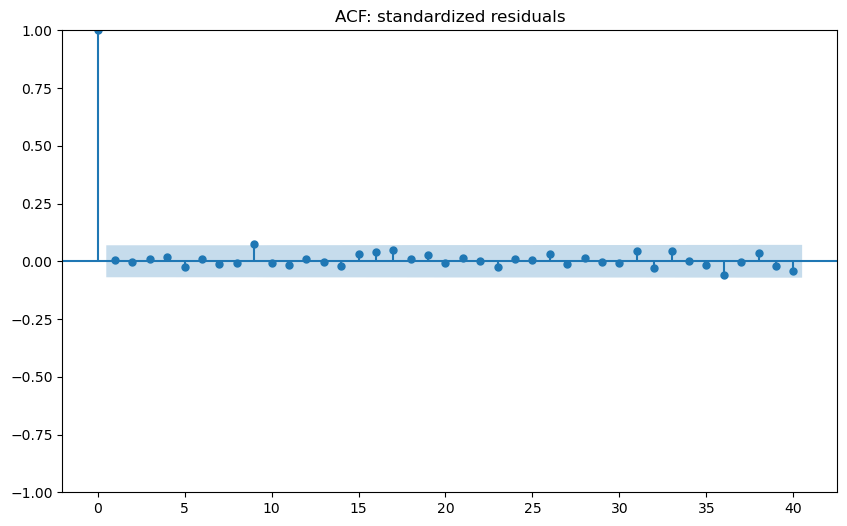

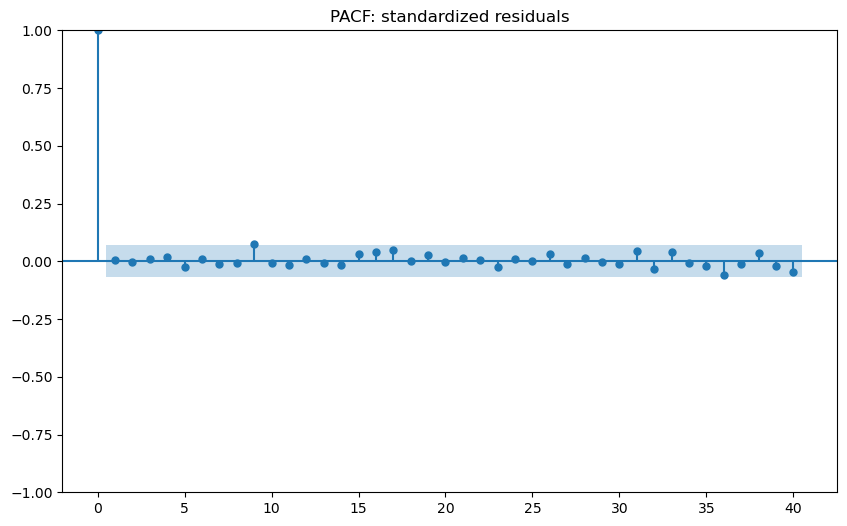

      lb_stat  lb_pvalue
10   5.605419   0.847254
20  10.955381   0.947371
30  13.158290   0.996701


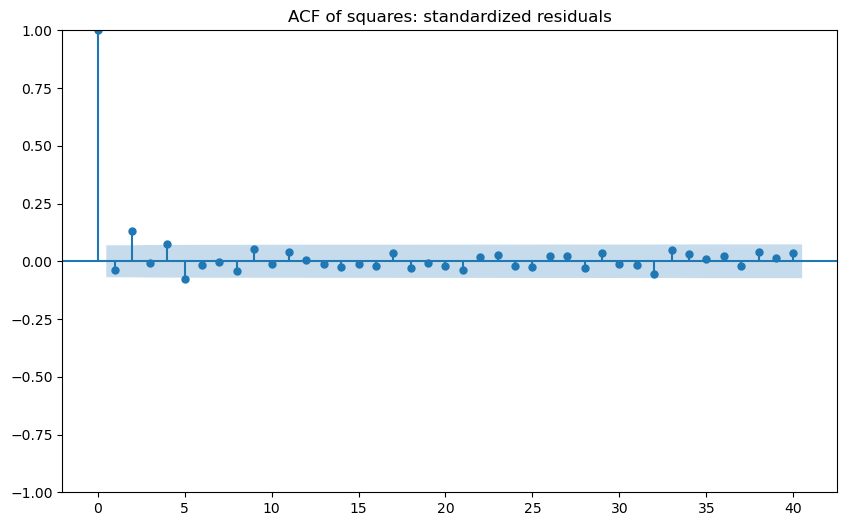

      lb_stat  lb_pvalue
10  28.229506   0.001659
20  32.612759   0.037191
30  38.379560   0.140246


In [ ]:
#we can see that the squared residuals have significant lags, so it means there is variance dynamics
#There is non-linear dependence in the mean that a linear MA(3) didn’t remove. 
#There is dependence in the variance

#Not Asked in question:

#so now modelling the variance with a GARCH fit on the residuals - using GARCH(1,1) with t-distribution
g = arch_model(resid_ma3, mean='Zero', vol='GARCH', p=1, q=1, dist='t')  
g_res = g.fit(update_freq=0, disp='off')
print(g_res.summary())

# Standardized residuals (should be i.i.d. if variance is captured)
std_resid = g_res.resid / g_res.conditional_volatility

#If the variance model did its job, these should now look i.i.d.
plot_acf(std_resid, lags=40); plt.title("ACF: standardized residuals"); plt.show()
plot_pacf(std_resid, lags=40, method='ywm'); plt.title("PACF: standardized residuals"); plt.show()
print(acorr_ljungbox(std_resid, lags=[10,20,30], return_df=True))

# ARCH left?
plot_acf((std_resid - std_resid.mean())**2, lags=40); plt.title("ACF of squares: standardized residuals"); plt.show()
print(acorr_ljungbox((std_resid - std_resid.mean())**2, lags=[10,20,30], return_df=True))


In [54]:
#the residuals got standardised but the squred residuals still have some significant lags, so we can try to fit a more complex GARCH model or a different one.

def fit_vol(resid_ma3, vol='GARCH', p=1, o=0, q=1, dist='t'):
    # Map 'GJR-GARCH' to 'GARCH' for arch_model
    vol_model = 'GARCH' if vol == 'GJR-GARCH' else vol
    am = arch_model(resid_ma3, mean='Zero', vol=vol_model, p=p, o=o, q=q, dist=dist)
    res = am.fit(disp='off')
    std_resid_ma3 = res.resid / res.conditional_volatility
    lb_raw = acorr_ljungbox(std_resid_ma3, lags=[10,20,30], return_df=True)
    lb_sq  = acorr_ljungbox((std_resid_ma3 - std_resid_ma3.mean())**2, lags=[10,20,30], return_df=True)
    return res, std_resid_ma3, lb_raw, lb_sq

cands = [
    ('GARCH',1,0,1), ('GARCH',1,0,2), ('GARCH',2,0,1), ('GARCH',2,0,2),
    ('GJR-GARCH',1,1,1), ('EGARCH',1,1,1)
]

rows, store = [], {}
for vol,p,o,q in cands:
    res, std_resid_ma3, lb_raw, lb_sq = fit_vol(resid_ma3, vol=vol, p=p, o=o, q=q, dist='t')
    rows.append({
        "vol": vol, "p": p, "o": o, "q": q,
        "BIC": res.bic,
        "LB_raw_p@20": float(lb_raw["lb_pvalue"].iloc[1]),
        "LB_sq_p@20":  float(lb_sq["lb_pvalue"].iloc[1]),
    })
    store[(vol,p,o,q)] = (res, std_resid_ma3, lb_raw, lb_sq)

tbl = pd.DataFrame(rows).sort_values(["LB_sq_p@20","BIC"], ascending=[False, True])
print(tbl)

         vol  p  o  q          BIC  LB_raw_p@20  LB_sq_p@20
3      GARCH  2  0  2  3414.751721     0.896310    0.555444
2      GARCH  2  0  1  3408.067110     0.896320    0.555413
5     EGARCH  1  1  1  3398.723285     0.868401    0.122007
1      GARCH  1  0  2  3420.002543     0.947369    0.037196
0      GARCH  1  0  1  3413.317931     0.947371    0.037191
4  GJR-GARCH  1  1  1  3415.356088     0.924537    0.003002


c:\Users\snehi\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [55]:
#We require the squared–residual Ljung–Box p-value to be > 0.05 (no remaining ARCH at that horizon).
#Passing at @20: EGARCH(1,1), GARCH(2,1), GARCH(2,2). The others fail. Now we need to check p-values at 10 and 30 for those 2–3 finalists, and then pick by lowest BIC among the ones that pass.

# finalists you want to inspect more closely
finalists = [
    ('EGARCH',1,1,1),
    ('GARCH',2,0,1),
    ('GARCH',2,0,2),
]

for key in finalists:
    res, std_resid_ma3, lb_raw, lb_sq = store[key]
    print("\nModel:", key)
    print("BIC:", res.bic)
    print("LB raw p-values (10,20,30):\n", lb_raw["lb_pvalue"])
    print("LB squares p-values (10,20,30):\n", lb_sq["lb_pvalue"])



Model: ('EGARCH', 1, 1, 1)
BIC: 3398.7232850094347
LB raw p-values (10,20,30):
 10    0.751941
20    0.868401
30    0.980129
Name: lb_pvalue, dtype: float64
LB squares p-values (10,20,30):
 10    0.014301
20    0.122007
30    0.222355
Name: lb_pvalue, dtype: float64

Model: ('GARCH', 2, 0, 1)
BIC: 3408.0671095364646
LB raw p-values (10,20,30):
 10    0.710616
20    0.896320
30    0.992569
Name: lb_pvalue, dtype: float64
LB squares p-values (10,20,30):
 10    0.155058
20    0.555413
30    0.746697
Name: lb_pvalue, dtype: float64

Model: ('GARCH', 2, 0, 2)
BIC: 3414.7517212892812
LB raw p-values (10,20,30):
 10    0.710593
20    0.896310
30    0.992568
Name: lb_pvalue, dtype: float64
LB squares p-values (10,20,30):
 10    0.155075
20    0.555444
30    0.746715
Name: lb_pvalue, dtype: float64


                          Zero Mean - GARCH Model Results                           
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.001
Vol Model:                            GARCH   Log-Likelihood:               -1687.32
Distribution:      Standardized Student's t   AIC:                           3384.64
Method:                  Maximum Likelihood   BIC:                           3408.07
                                              No. Observations:                  800
Date:                      Tue, Sep 30 2025   Df Residuals:                      800
Time:                              18:23:30   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          2

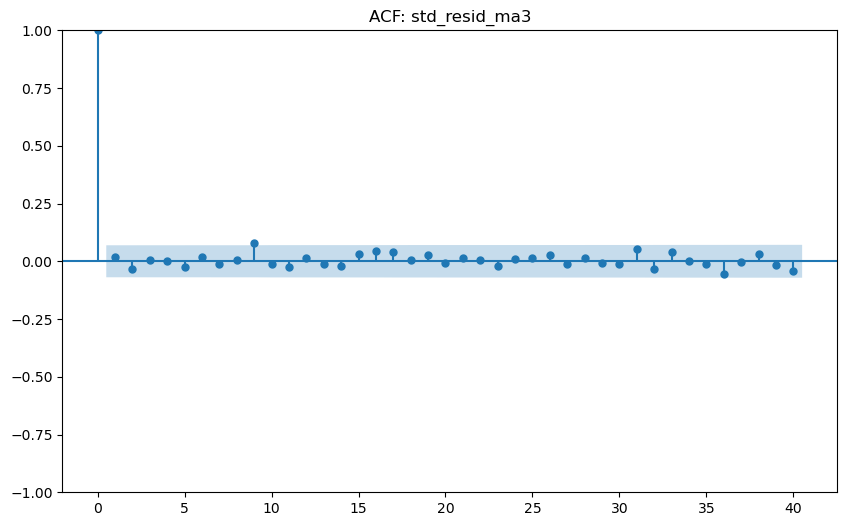

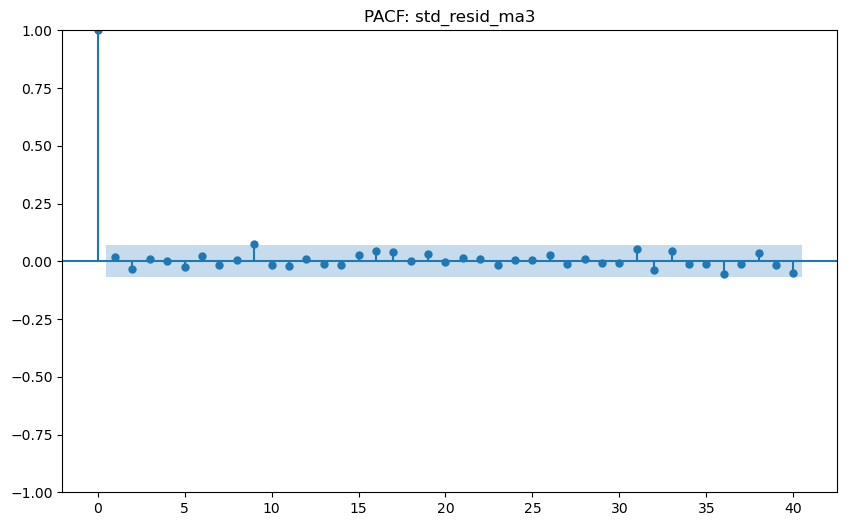

LB raw p-values:
       lb_stat  lb_pvalue
10   7.156258   0.710616
20  12.537879   0.896320
30  14.433678   0.992569
LB squares p-values:
       lb_stat  lb_pvalue
10  14.410952   0.155058
20  18.486201   0.555413
30  24.547785   0.746697


In [56]:
#from teh above results we get that GARCH(2,0,2) is the best model as it has the highest p-values for both raw and squared residuals and also has the lowest BIC value among the three models. So we can say that the final model is MA(3)-GARCH(2,0,2)

#fittin the chosen volatility model on MA(3) residuals
am_best = arch_model(resid_ma3, mean='Zero', vol='GARCH', p=2, q=1, dist='t')
g_best = am_best.fit(disp='off', update_freq=0)
print(g_best.summary())

#Standardized residuals (should be i.i.d. if variance is modeled well)
std_resid_ma3 = g_best.resid / g_best.conditional_volatility

#final linear checks
plot_acf(std_resid_ma3, lags=40); plt.title("ACF: std_resid_ma3"); plt.show()
plot_pacf(std_resid_ma3, lags=40, method='ywm'); plt.title("PACF: std_resid_ma3"); plt.show()
print("LB raw p-values:\n", acorr_ljungbox(std_resid_ma3, lags=[10,20,30], return_df=True))
print("LB squares p-values:\n", acorr_ljungbox((std_resid_ma3-std_resid_ma3.mean())**2,
                                               lags=[10,20,30], return_df=True))

In [57]:
# assuming ldf_one_lag / ldf_with_bands already defined
K = 20
vals, los, his = [], [], []
for k in range(1, K+1):
    v, lo, hi = ldf_with_bands(std_resid_ma3, k, nboot=300, frac=0.3)
    vals.append(v); los.append(lo); his.append(hi)

# which lags (if any) are still significant?
sig_lags_after = [k for k in range(1, K+1) if vals[k-1] < los[k-1] or vals[k-1] > his[k-1]]
print("Significant LDF lags after GARCH(2,1):", sig_lags_after)

Significant LDF lags after GARCH(2,1): [1, 2, 3, 4, 6]


In [61]:
import numpy as np, pandas as pd, statsmodels.api as sm

def build_lag_matrix(y, p):
    X = np.column_stack([y.shift(i) for i in range(1, p+1)])
    return pd.DataFrame(X, index=y.index)

def fit_ols(y, X):
    Xc = sm.add_constant(X, has_constant='add')
    return sm.OLS(y, Xc, missing='drop').fit()

def setar_fit(y, p=2, delay=1, q_lo=0.15, q_hi=0.85, n_grid=50):
    """
    Two-regime SETAR with AR(p) in each regime, threshold on y_{t-delay}.
    Returns dict with best threshold, models, residuals, BIC.
    """
    y = pd.Series(y).astype(float)
    Xlags = build_lag_matrix(y, p)
    z = y.shift(delay)                        # threshold variable
    df = pd.concat([y.rename('y'), Xlags, z.rename('z')], axis=1).dropna()
    yv = df['y']; X = df.iloc[:, 1:-1]; z = df['z']

    lo, hi = z.quantile([q_lo, q_hi])
    grid = np.linspace(lo, hi, n_grid)
    best = None

    for r in grid:
        left_mask  = z <= r
        right_mask = z >  r
        # need at least p+2 obs per side to estimate
        if left_mask.sum() <= (p+2) or right_mask.sum() <= (p+2):
            continue

        mL = fit_ols(yv[left_mask],  X[left_mask])
        mR = fit_ols(yv[right_mask], X[right_mask])

        # predictions stacked in original order
        yhat = pd.Series(index=df.index, dtype=float)
        yhat[left_mask]  = mL.predict(sm.add_constant(X[left_mask], has_constant='add'))
        yhat[right_mask] = mR.predict(sm.add_constant(X[right_mask], has_constant='add'))

        res = (yv - yhat).dropna()
        # BIC: k params = (p+1) per regime
        k = (p+1) * 2
        n = res.shape[0]
        sse = np.sum(res**2)
        sigma2 = sse/n
        bic = n*np.log(sigma2) + k*np.log(n)

        cand = {"r": r, "p": p, "delay": delay, "bic": bic,
                "mL": mL, "mR": mR, "resid": res, "yhat": yhat}
        if (best is None) or (bic < best["bic"]):
            best = cand
    return best

delays = [1,2,3,4,6]     # from your LDF result
results = []
for d in delays:
    best = setar_fit(y, p=2, delay=d)  # start with p=2; try p=1,3 if you like
    if best is not None:
        results.append(best)

# Pick the winner by lowest BIC
best_setar = sorted(results, key=lambda r: r["bic"])[0]
print("SETAR best: delay =", best_setar["delay"], "threshold r =", best_setar["r"], "BIC =", best_setar["bic"])
resid_setar = best_setar["resid"]


SETAR best: delay = 2 threshold r = 1.9995008597588355 BIC = 768.4262431268733


In [76]:
# part5_solution.py
# ------------------------------------------------------------
# DTU CDA - Part 5 solution scaffold (Python)
# Your ideation:
#   - Plot series (stationary yet nonlinear),
#   - ACF/PACF + Ljung–Box -> try MA(3) (and neighbors),
#   - Use LDF to reveal nonlinear dependence in residuals,
#   - Propose a better model (2-regime SETAR on residuals).
# ------------------------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller

# ---------- R-style LDF (your provided logic; lightly wrapped) ----------
from statsmodels.nonparametric.kernel_regression import KernelReg  # local linear + CV h

def _smooth_cv(x, y):
    kr = KernelReg(endog=y, exog=x, var_type='c', reg_type='ll')
    yhat, _ = kr.fit(x)
    return yhat

def ldf_one_lag_Rstyle(e, k, signed=False):
    e = np.asarray(e)
    if k <= 0 or k >= len(e):
        return np.nan
    x, y = e[:-k], e[k:]
    yhat = _smooth_cv(x, y)
    RSS  = np.sum((y - y.mean())**2)
    RSSk = np.sum((y - yhat)**2)
    R2   = max(0.0, 1.0 - RSSk / RSS)
    if not signed:
        return R2
    i_min, i_max = np.argmin(x), np.argmax(x)
    sgn = np.sign(yhat[i_max] - yhat[i_min])
    return float(sgn * np.sqrt(R2))

def ldf_with_band_Rstyle(e, k, nboot=30, signed=False, seed=42):
    rng = np.random.default_rng(seed)
    val = ldf_one_lag_Rstyle(e, k, signed=signed)
    n = len(e); m = min(n, 100)
    boots = []
    for _ in range(nboot):
        xr = rng.choice(e, size=m, replace=True)
        boots.append(ldf_one_lag_Rstyle(xr, 1, signed=signed))
    upper95 = np.quantile(boots, 0.95)
    return val, upper95

def ldf_series_Rstyle(e, K, nboot=30, signed=False, seed=42):
    vals, upp = [], []
    for k in range(1, K+1):
        v, u = ldf_with_band_Rstyle(e, k, nboot=nboot, signed=signed, seed=seed)
        vals.append(v); upp.append(u)
    return np.array(vals), np.array(upp)

def plot_ldf_Rstyle(vals, upp, outpath, title="LDF (R-style)", signed=False):
    x = np.arange(1, len(vals)+1)
    plt.figure(figsize=(9,4))
    plt.vlines(x, 0, vals)
    plt.scatter(x, vals, s=24)
    if signed:
        plt.plot(x, upp, '--'); plt.plot(x, -upp, '--')
    else:
        plt.plot(x, upp, '--')
    plt.axhline(0, lw=0.8)
    plt.xlabel("lag k"); plt.ylabel("LDF" + (" (signed √R²)" if signed else " (R²)"))
    plt.title(title)
    sig = (np.abs(vals) > upp) if signed else (vals > upp)
    sig_lags = x[sig]
    if sig.any():
        plt.scatter(x[sig], vals[sig], s=70)
        for xi, yi in zip(x[sig], vals[sig]):
            plt.text(xi, yi + (0.02 if yi>=0 else -0.02), f"k={xi}", ha='center',
                     va='bottom' if yi>=0 else 'top', fontsize=9)
    plt.tight_layout()
    plt.savefig(outpath, dpi=160)
    plt.close()
    return sig_lags.tolist()

# ---------- helpers ----------
def ljungbox_table(resid, lags=(10,20,30), alpha=0.05):
    out = acorr_ljungbox(resid, lags=lags, return_df=True)  # columns lb_stat, lb_pvalue
    out['reject@{:.2f}'.format(alpha)] = out['lb_pvalue'] < alpha
    return out

def try_arima_grid(y, grid):
    rows = []
    fits = {}
    for p,q in grid:
        try:
            m = ARIMA(y, order=(p,0,q)).fit()
            rows.append((p,q,m.aic,m.bic))
            fits[(p,q)] = m
        except Exception:
            continue
    if not rows:
        return pd.DataFrame(columns=['p','q','AIC','BIC']), fits
    df = pd.DataFrame(rows, columns=['p','q','AIC','BIC']).sort_values(['AIC','BIC'])
    return df, fits

def scatter_et_vs_etk(e, k, outpath):
    x, y = e[:-k], e[k:]
    plt.figure(figsize=(4.5,4.5))
    plt.scatter(x, y, s=8, alpha=0.6)
    plt.xlabel(f"$e_{{t-{k}}}$"); plt.ylabel("$e_t$")
    plt.title(f"Residual dependence: $e_t$ vs $e_{{t-{k}}}$")
    plt.tight_layout()
    plt.savefig(outpath, dpi=160)
    plt.close()

# ---------- main workflow ----------
def main(data_path=None, max_ldf_lag=12, alpha=0.05):
    outdir = Path("part5_outputs"); outdir.mkdir(exist_ok=True)
    # Use existing df if data_path is None, else read from file
    global df
    if data_path is not None:
        df = pd.read_csv(data_path)

    # Pick first numeric column as series
    if df.shape[1] == 1:
        y = df.iloc[:,0].astype(float).to_numpy()
        yname = df.columns[0]
    else:
        numcols = df.select_dtypes(include=[np.number]).columns
        yname = numcols[0]
        y = df[yname].astype(float).to_numpy()

    # --- Plot series (stationary but nonlinear by visual assessment) ---
    plt.figure(figsize=(10,3))
    plt.plot(y, lw=1)
    plt.title(f"{yname} (visual: stationary; nonlinear fluctuations)")
    plt.tight_layout(); plt.savefig(outdir/"series.png", dpi=160); plt.close()

    # ADF (just to document stationarity)
    adf_stat, adf_p, *_ = adfuller(y, autolag='AIC')

    # --- ACF/PACF ---
    plot_acf(y, lags=40)
    plt.tight_layout(); plt.savefig(outdir/"acf.png", dpi=160); plt.close()

    plot_pacf(y, lags=40, method='ywm')
    plt.tight_layout(); plt.savefig(outdir/"pacf.png", dpi=160); plt.close()

    # --- small ARMA grid & Ljung–Box on residuals ---
    cand_grid = [(0,1),(0,2),(0,3),(0,4),
                 (1,0),(2,0),(3,0),
                 (1,1),(1,2),(2,1),(2,2),(3,1)]
    grid_tbl, fits = try_arima_grid(y, cand_grid)

    # prefer MA(3) per ideation but show neighbors for context
    prefer = None
    for key in [(0,3),(2,0),(1,1)]:
        if key in fits: prefer = key; break
    if prefer is None and len(fits):
        prefer = min(fits.keys(), key=lambda k: fits[k].aic)

    arma = fits[prefer]
    resid = arma.resid

    lj = ljungbox_table(resid, lags=(10,20,30), alpha=alpha)

    # --- LDF on ARMA residuals to detect nonlinearity ---
    K = max_ldf_lag
    vals, upp = ldf_series_Rstyle(resid, K, nboot=60, signed=False, seed=123)
    sig_lags = plot_ldf_Rstyle(vals, upp, outdir/"ldf_unsigned.png",
                               title="LDF of ARMA residuals (R-style, unsigned R²)",
                               signed=False)

    # also “signed sqrt” version for directionality (optional)
    vals_s, upp_s = ldf_series_Rstyle(resid, K, nboot=60, signed=True, seed=123)
    sig_lags_s = plot_ldf_Rstyle(vals_s, upp_s, outdir/"ldf_signed.png",
                                 title="LDF of ARMA residuals (signed √R²)",
                                 signed=True)

    # scatter at top significant LDF lag (if any)
    chosen_ldf_k = sig_lags[0] if len(sig_lags) else 1
    scatter_et_vs_etk(resid, chosen_ldf_k, outdir/f"et_vs_et-{chosen_ldf_k}.png")

    # --- simple 2-regime SETAR on residuals (better nonlinear structure)
    # Regimes by threshold on e_{t-k} (median split); fit AR(1) per regime on residuals.
    k = chosen_ldf_k
    e = resid.copy()
    x = e[:-k]; ydep = e[k:]
    thr = np.median(x)

    reg_lo = x <= thr
    reg_hi = x > thr

    # AR(1) within each regime: y_t = c + phi * y_{t-1} + u_t  (but we use predictors [1, e_{t-1}])
    # For simplicity we forecast with regime-specific constants and slopes on e_{t-1}.
    # Align e_{t-1} with ydep:
    z = e[k-1:-1]  # lag-1 of e aligned with ydep

    import statsmodels.api as sm
    def fit_reg(mask):
        X = np.column_stack([np.ones(z[mask].shape[0]), z[mask]])
        return sm.OLS(ydep[mask], X).fit()

    mdl_lo = fit_reg(reg_lo)
    mdl_hi = fit_reg(reg_hi)

    # Fitted residuals from SETAR layer (piecewise AR on e)
    yhat = np.empty_like(ydep)
    X_lo = np.column_stack([np.ones(z[reg_lo].shape[0]), z[reg_lo]])
    X_hi = np.column_stack([np.ones(z[reg_hi].shape[0]), z[reg_hi]])
    yhat[reg_lo] = mdl_lo.predict(X_lo)
    yhat[reg_hi] = mdl_hi.predict(X_hi)
    setar_resid = ydep - yhat

    # whiteness check again
    lj_setar = ljungbox_table(setar_resid, lags=(10,20,30), alpha=alpha)

    # Save tables
    with pd.ExcelWriter(outdir/"part5_results.xlsx") as xl:
        grid_tbl.to_excel(xl, "ARMA_grid", index=False)
        pd.DataFrame({"ADF_stat":[adf_stat], "ADF_pvalue":[adf_p]}).to_excel(xl, "ADF", index=False)
        lj.to_excel(xl, "LjungBox_ARMAresid")
        lj_setar.to_excel(xl, "LjungBox_SETARresid")
        pd.DataFrame({"k":np.arange(1,K+1), "LDF_R2":vals, "Upper95":upp}).to_excel(xl, "LDF_unsigned", index=False)
        pd.DataFrame({"k":np.arange(1,K+1), "LDF_signed_sqrt":vals_s, "Band":upp_s}).to_excel(xl, "LDF_signed", index=False)
        pd.DataFrame({"chosen_ldf_k":[chosen_ldf_k],
                      "sig_lags_unsigned":[sig_lags],
                      "sig_lags_signed":[sig_lags_s],
                      "threshold":[thr],
                      "ARMA_prefer":[str(prefer)],
                      "ARMA_aic":[arma.aic],
                      "ARMA_bic":[arma.bic]}).to_excel(xl, "Summary", index=False)

    # Console summary for your report text
    print("\n=== Visual diagnosis ===")
    print("Series appears stationary (ADF p≈{:.3g}), but nonlinear by visual fluctuations.".format(adf_p))
    print("\n=== ARMA grid (top 8 by AIC) ===")
    print(grid_tbl.head(8).to_string(index=False))
    print(f"\nSelected ARMA(p,q) by your ideation: {prefer}  "
          f"(AIC={arma.aic:.3f}, BIC={arma.bic:.3f})")

    print("\nResidual whiteness after ARMA (Ljung–Box):")
    print(lj.to_string())

    print("\nLDF (unsigned R²) significant lags:", sig_lags)
    print("LDF (signed √R²)   significant lags:", sig_lags_s)
    print(f"Using k={chosen_ldf_k} to define SETAR regimes; threshold = median(e_{'{t-%d}'%k}) = {thr:.4f}")

    print("\nTwo-regime SETAR on residuals (piecewise AR(1)) coefficients:")
    print("Regime LOW (e_{t-k} ≤ thr):", mdl_lo.params, "| R²={:.3f}".format(mdl_lo.rsquared))
    print("Regime HIGH(e_{t-k} > thr):", mdl_hi.params, "| R²={:.3f}".format(mdl_hi.rsquared))

    print("\nResidual whiteness after ARMA + SETAR layer (Ljung–Box):")
    print(lj_setar.to_string())

if __name__ == "__main__":
    # Use already loaded df in notebook, do not read from file.
    main(data_path=None, max_ldf_lag=12, alpha=0.05)
if __name__ == "__main__":
    # Point to your uploaded file (same folder or absolute path).
    main(data_path="DataPart5.csv", max_ldf_lag=12, alpha=0.05)


KeyboardInterrupt: 